# part-1: training an autoencoder as a 2D feature generator and displaying CIFAR10 dataset's features

# Install and Import Required Libraries

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

Using device: cuda


# Define Autoencoder Model

In [113]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder().to(device)

In [114]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# Train the Autoencoder

In [115]:
print("Training...")
for epoch in range(epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")

Training...
Epoch [1/30], Loss: 0.0389
Epoch [2/30], Loss: 0.0368
Epoch [3/30], Loss: 0.0363
Epoch [4/30], Loss: 0.0359
Epoch [5/30], Loss: 0.0354
Epoch [6/30], Loss: 0.0351
Epoch [7/30], Loss: 0.0349
Epoch [8/30], Loss: 0.0350
Epoch [9/30], Loss: 0.0352
Epoch [10/30], Loss: 0.0348
Epoch [11/30], Loss: 0.0348
Epoch [12/30], Loss: 0.0346
Epoch [13/30], Loss: 0.0346
Epoch [14/30], Loss: 0.0344
Epoch [15/30], Loss: 0.0344
Epoch [16/30], Loss: 0.0343
Epoch [17/30], Loss: 0.0343
Epoch [18/30], Loss: 0.0342
Epoch [19/30], Loss: 0.0340
Epoch [20/30], Loss: 0.0344
Epoch [21/30], Loss: 0.0342
Epoch [22/30], Loss: 0.0342
Epoch [23/30], Loss: 0.0343
Epoch [24/30], Loss: 0.0340
Epoch [25/30], Loss: 0.0346
Epoch [26/30], Loss: 0.0346
Epoch [27/30], Loss: 0.0342
Epoch [28/30], Loss: 0.0343
Epoch [29/30], Loss: 0.0344
Epoch [30/30], Loss: 0.0339


# Extract 2D Features from Encoder

In [116]:
print("Extracting features...")
features = []
labels = []
with torch.no_grad():
    for i, (images, lbls) in enumerate(trainloader):
        if i * 128 > 3000:
            break
        images = images.to(device)
        z = model.encoder(images)
        features.append(z.cpu())
        labels.append(lbls)

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()



Extracting features...


# Plot the 2D Features

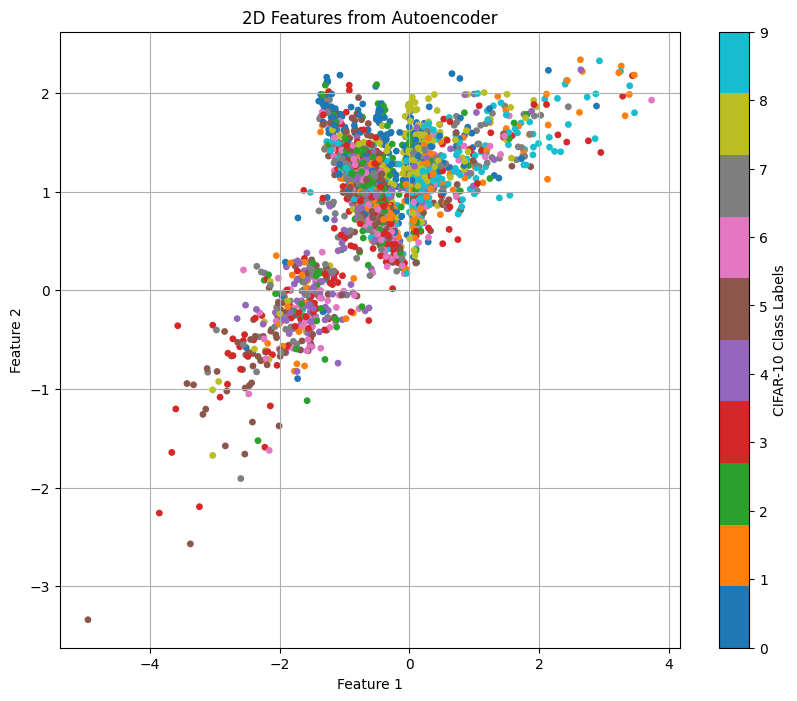

In [117]:

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', s=15)
plt.colorbar(scatter, ticks=range(10), label='CIFAR-10 Class Labels')
plt.title("2D Features from Autoencoder")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


# Part-2: comparing autoencoder generated features with features extracted by a pre-trained CNN and reduced by dimension reduction techniques like PCA, t-SNE.

In [118]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = mobilenet.to(device)
mobilenet.eval()

feature_extractor = mobilenet.features

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

cnn_features = []
cnn_labels = []

print("Extracting features using MobileNetV2...")
with torch.no_grad():
    for i, (images, lbls) in enumerate(testloader):
        if i * 128 > 3000:
            break
        images = images.to(device)
        feats = feature_extractor(images)
        feats = feats.mean([2, 3])
        cnn_features.append(feats.cpu())
        cnn_labels.append(lbls)


cnn_features = torch.cat(cnn_features).numpy()
cnn_labels = torch.cat(cnn_labels).numpy()

print("Reducing with PCA...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cnn_features)

print("Reducing with t-SNE (takes some time)...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(cnn_features)


Extracting features using MobileNetV2...
Reducing with PCA...
Reducing with t-SNE (takes some time)...


# Plot PCA & t-SNE Result

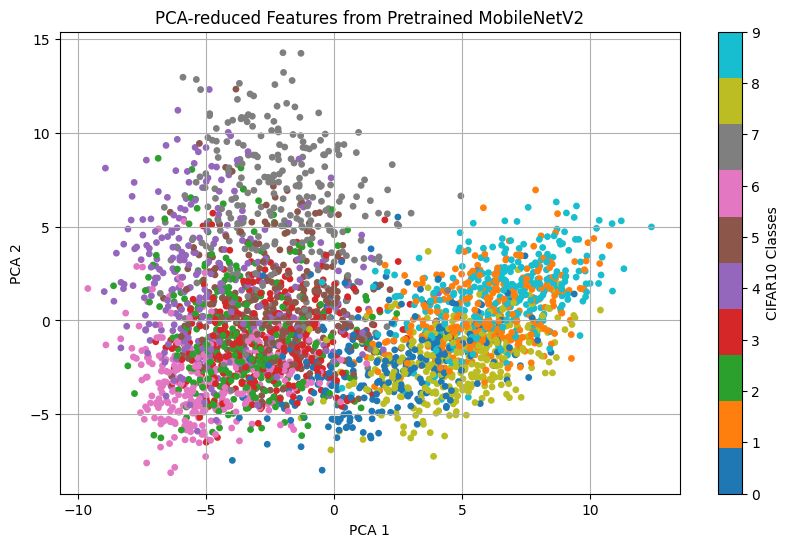

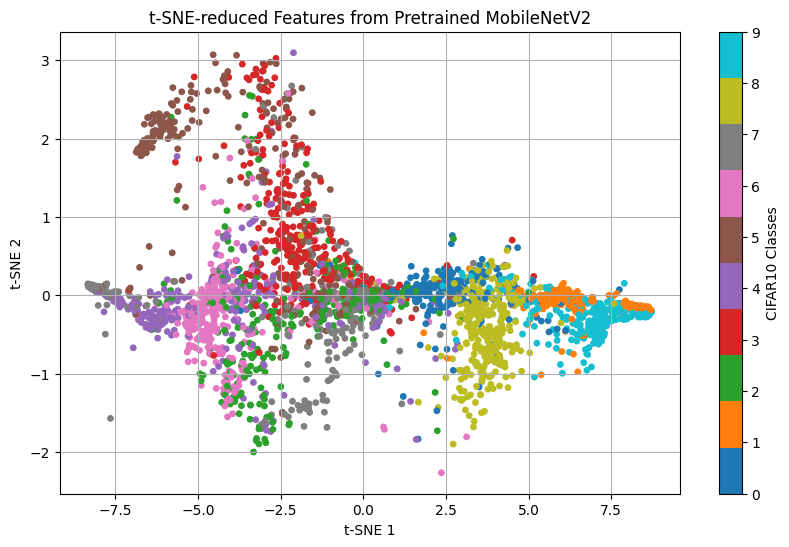

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cnn_labels, cmap='tab10', s=15)
plt.title("PCA-reduced Features from Pretrained MobileNetV2")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="CIFAR10 Classes")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cnn_labels, cmap='tab10', s=15)
plt.title("t-SNE-reduced Features from Pretrained MobileNetV2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="CIFAR10 Classes")
plt.grid(True)
plt.show()


# part-3: training a denoising autoencoder for CIFAR10 dataset

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [30]:
transform = transforms.ToTensor()

In [31]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [32]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
denoise_model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoise_model.parameters(), lr=0.001)

In [34]:
def add_noise(imgs, noise_factor=0.1):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

In [35]:
epochs = 10
print("Training denoising autoencoder...")
for epoch in range(epochs):
    running_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs)

        outputs = denoise_model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")

Training denoising autoencoder...
Epoch [1/10], Loss: 0.0308
Epoch [2/10], Loss: 0.0215
Epoch [3/10], Loss: 0.0193
Epoch [4/10], Loss: 0.0175
Epoch [5/10], Loss: 0.0165
Epoch [6/10], Loss: 0.0157
Epoch [7/10], Loss: 0.0151
Epoch [8/10], Loss: 0.0146
Epoch [9/10], Loss: 0.0142
Epoch [10/10], Loss: 0.0140


# Visualize Results (Noisy vs Denoised)

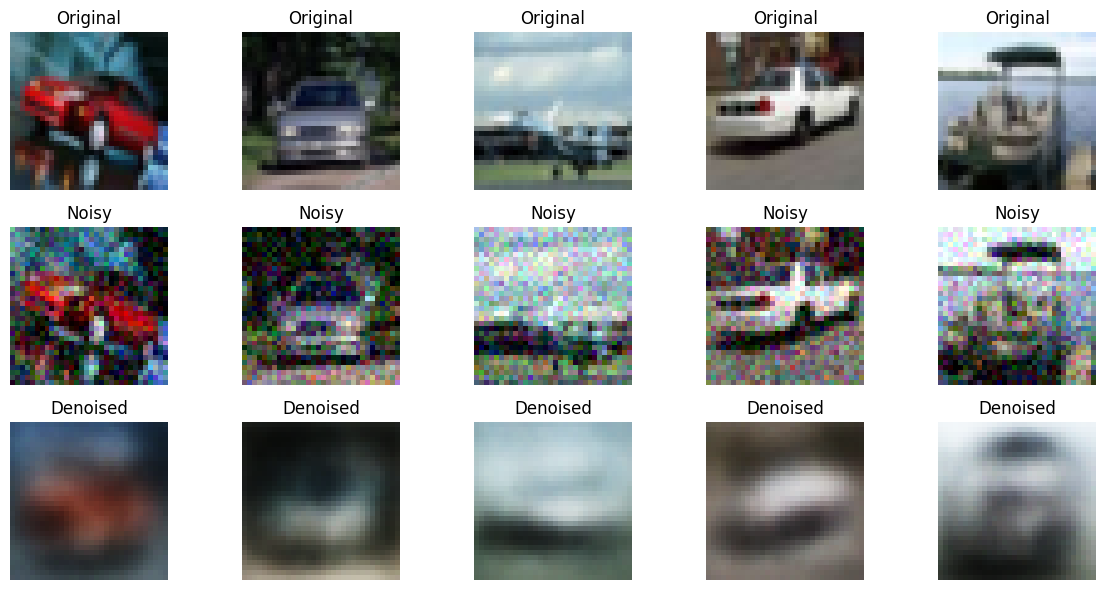

In [36]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images.to(device)
noisy_images = add_noise(images)
outputs = denoise_model(noisy_images)

images = images.cpu()
noisy_images = noisy_images.cpu()
outputs = outputs.detach().cpu()

def imshow(img, title=""):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    imshow(images[i], "Original")

    plt.subplot(3, 5, i+6)
    imshow(noisy_images[i], "Noisy")

    plt.subplot(3, 5, i+11)
    imshow(outputs[i], "Denoised")

plt.tight_layout()
plt.show()


In [38]:
class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(ConvDenoisingAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:

conv_model = ConvDenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=0.001)

In [40]:

print("Training convolutional denoising autoencoder...")
for epoch in range(10):
    running_loss = 0.0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, noise_factor=0.1)

        outputs = conv_model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(trainloader):.4f}")

Training convolutional denoising autoencoder...
Epoch [1/10], Loss: 0.0149
Epoch [2/10], Loss: 0.0062
Epoch [3/10], Loss: 0.0054
Epoch [4/10], Loss: 0.0050
Epoch [5/10], Loss: 0.0047
Epoch [6/10], Loss: 0.0045
Epoch [7/10], Loss: 0.0044
Epoch [8/10], Loss: 0.0042
Epoch [9/10], Loss: 0.0041
Epoch [10/10], Loss: 0.0040


# Visualize results (Noisy vs Denoised using new model)

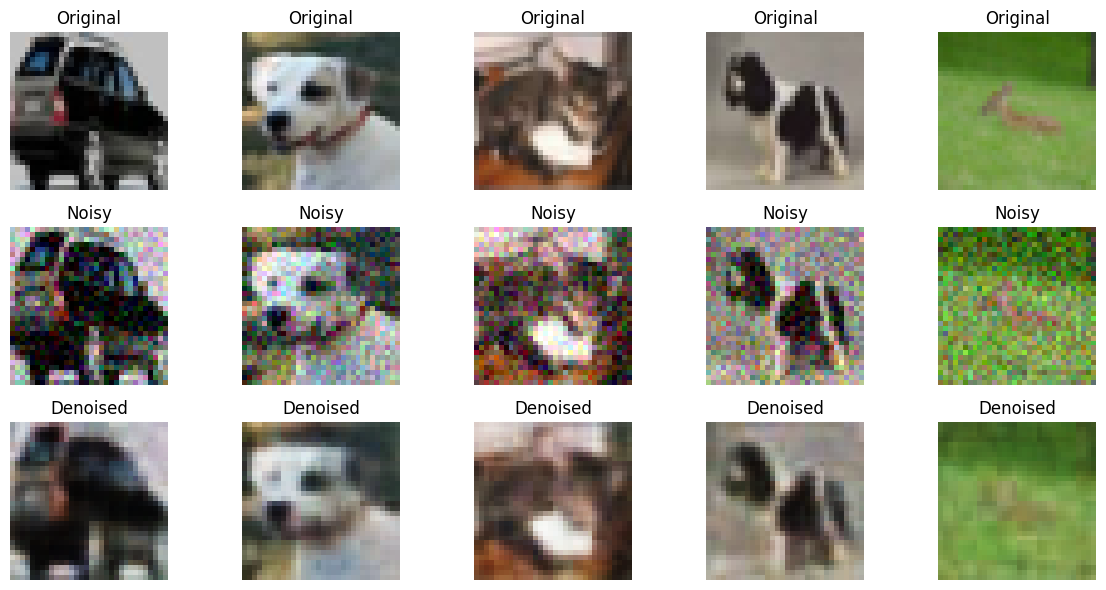

In [43]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images.to(device)
noisy_images = add_noise(images, noise_factor=0.1)
outputs = conv_model(noisy_images)

images = images.cpu()
noisy_images = noisy_images.cpu()
outputs = outputs.detach().cpu()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    imshow(images[i], "Original")

    plt.subplot(3, 5, i+6)
    imshow(noisy_images[i], "Noisy")

    plt.subplot(3, 5, i+11)
    imshow(outputs[i], "Denoised")

plt.tight_layout()
plt.show()


# part-4: training a CNN based CIFAR-10 classifier without any single-image data augmentation techniques

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [48]:
transform_plain = transforms.Compose([
    transforms.ToTensor()
])

In [49]:
trainset_plain = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_plain)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_plain)

trainloader_plain = torch.utils.data.DataLoader(trainset_plain, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model_plain = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_plain.parameters(), lr=0.001)

In [51]:
print("Training without augmentation...")
for epoch in range(10):
    running_loss = 0
    correct = 0
    total = 0
    model_plain.train()
    for images, labels in trainloader_plain:
        images, labels = images.to(device), labels.to(device)
        outputs = model_plain(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader_plain):.4f}, Accuracy: {acc:.2f}%")


Training without augmentation...
Epoch 1, Loss: 1.4310, Accuracy: 48.49%
Epoch 2, Loss: 1.0530, Accuracy: 62.80%
Epoch 3, Loss: 0.9016, Accuracy: 68.57%
Epoch 4, Loss: 0.7893, Accuracy: 72.41%
Epoch 5, Loss: 0.6981, Accuracy: 75.57%
Epoch 6, Loss: 0.6162, Accuracy: 78.25%
Epoch 7, Loss: 0.5335, Accuracy: 81.33%
Epoch 8, Loss: 0.4595, Accuracy: 84.03%
Epoch 9, Loss: 0.3814, Accuracy: 86.80%
Epoch 10, Loss: 0.3208, Accuracy: 88.88%


# part-5: training a CNN based CIFAR-10 classifier with a single/multiple single-image data augmentation techniques

In [52]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

In [53]:
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_aug)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=64, shuffle=True)

In [54]:
model_aug = SimpleCNN().to(device)
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

In [55]:
print("Training WITH augmentation...")
for epoch in range(10):
    running_loss = 0
    correct = 0
    total = 0
    model_aug.train()
    for images, labels in trainloader_aug:
        images, labels = images.to(device), labels.to(device)
        outputs = model_aug(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader_aug):.4f}, Accuracy: {acc:.2f}%")


Training WITH augmentation...
Epoch 1, Loss: 1.5984, Accuracy: 41.67%
Epoch 2, Loss: 1.2868, Accuracy: 53.66%
Epoch 3, Loss: 1.1422, Accuracy: 59.30%
Epoch 4, Loss: 1.0608, Accuracy: 62.41%
Epoch 5, Loss: 0.9928, Accuracy: 64.87%
Epoch 6, Loss: 0.9441, Accuracy: 66.65%
Epoch 7, Loss: 0.9017, Accuracy: 68.15%
Epoch 8, Loss: 0.8688, Accuracy: 69.30%
Epoch 9, Loss: 0.8374, Accuracy: 70.93%
Epoch 10, Loss: 0.8159, Accuracy: 71.25%
